In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holidays
from models.D_PAD_adpGCN import DPAD_GCN
from models.LSTM import LSTM
from models.GRU import GRU
from models.MLP import MLP
from models.xPatch import xPatch
from models.PatchMixer import PatchMixer
from models.Fredformer import Fredformer
import argparse

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.utils import resample
from sklearn.multioutput import MultiOutputRegressor


import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, Sampler

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import BasePredictionWriter
from lightning.pytorch import seed_everything

# Seed 
SEED = 42
seed_everything(SEED, workers=True)

Seed set to 42


42

In [2]:
def convert_to_hourly(data):

    # Remove unnecessary columns
    data = data.drop(columns=['Zip_Postal_Code'])

    # Convert date/time columns to datetime
    data['Start_DateTime'] = pd.to_datetime(data['Start_DateTime'])
    data['Charging_EndTime'] = pd.to_datetime(data['End_DateTime'])
    data['Charging_Time'] = pd.to_timedelta(data['Charging_Time'])

    ####################### CONVERT DATASET TO HOURLY  #######################

    hourly_rows = []

    # Iterate over each row in the dataframe to break charging sessions into hourly intervals
    for _, row in data.iterrows():
        start, end = row['Start_DateTime'], row['Charging_EndTime']
        energy = row['Energy_Consumption']

        hourly_intervals = pd.date_range(
            start=start.floor('1h'), end=end.ceil('1h'), freq='1h')
        total_duration = (end - start).total_seconds()

        for i in range(len(hourly_intervals) - 1):
            interval_start = max(start, hourly_intervals[i])
            interval_end = min(end, hourly_intervals[i+1])
            interval_duration = (interval_end - interval_start).total_seconds()

            # Calculate the energy consumption for the interval if interval is greater than 0 (Start and end time are different)
            if interval_duration > 0:
                energy_fraction = (interval_duration / total_duration) * energy

            hourly_rows.append({
                'Time': hourly_intervals[i],
                'Energy_Consumption': energy_fraction,
                "Session_Count": 1  # Count of sessions in the interval
            })

    hourly_df = pd.DataFrame(hourly_rows)

    hourly_df = hourly_df.groupby('Time').agg({
        'Energy_Consumption': 'sum',
        'Session_Count': 'sum'
    }).reset_index()

    # Convert the Time column to datetime
    hourly_df['Time'] = pd.to_datetime(
        hourly_df['Time'], format="%d-%m-%Y %H:%M:%S")
    hourly_df = hourly_df.set_index('Time')

    # Define time range for all 24 hours
    start_time = hourly_df.index.min().normalize()  # 00:00:00
    end_time = hourly_df.index.max().normalize() + pd.Timedelta(days=1) - pd.Timedelta(hours=1)  # 23:00:00

    # Change range to time_range_full, so from 00:00:00 to 23:00:00
    time_range_full = pd.date_range(start=start_time, end=end_time, freq='1h')
    hourly_df = hourly_df.reindex(time_range_full, fill_value=0)

    return hourly_df


def add_features(df):
  ####################### TIMED BASED FEATURES  #######################
  df['Day_of_Week'] = df.index.dayofweek
  df['Hour_of_Day'] = df.index.hour
  df['Month_of_Year'] = df.index.month
  df['Year'] = df.index.year
  df['Day/Night'] = (df['Hour_of_Day'] >= 6) & (df['Hour_of_Day'] <= 18)

  # Add holiday
  us_holidays = holidays.US(years=range(2018, 2023 + 1))
  df['IsHoliday'] = df.index.map(lambda x: 1 if x.date() in us_holidays else 0)

  # Add weekend
  df['Weekend'] = (df['Day_of_Week'] >= 5).astype(int)

  ####################### CYCLIC FEATURES  #######################

  df['HourSin'] = np.sin(2 * np.pi * df['Hour_of_Day'] / 24)
  df['HourCos'] = np.cos(2 * np.pi * df['Hour_of_Day'] / 24)
  df['DayOfWeekSin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
  df['DayOfWeekCos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
  df['MonthOfYearSin'] = np.sin(2 * np.pi * df['Month_of_Year'] / 12)
  df['MonthOfYearCos'] = np.cos(2 * np.pi * df['Month_of_Year'] / 12)

  ####################### SEASONAL FEATURES  #######################
  month_to_season = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2,
                     7: 2, 8: 2, 9: 3, 10: 3, 11: 3, 12: 0}
  df['Season'] = df['Month_of_Year'].map(month_to_season)

  ####################### HISTORICAL CONSUMPTION FEATURES  #######################
  df['Energy_Consumption_1h'] = df['Energy_Consumption'].shift(1)
  df['Energy_Consumption_6h'] = df['Energy_Consumption'].shift(6)
  df['Energy_Consumption_12h'] = df['Energy_Consumption'].shift(12)
  df['Energy_Consumption_24h'] = df['Energy_Consumption'].shift(24)
  df['Energy_Consumption_1w'] = df['Energy_Consumption'].shift(24*7)
  df['Energy_Consumption_rolling'] = df['Energy_Consumption'].rolling(window=24).mean()

  return df


def filter_data(start_date, end_date, data):
    return data[(data.index >= start_date) & (data.index <= end_date)].copy()


""" def create_multi_step_targets(data, horizon): 
    return np.stack([data.shift(-i) for i in range(1, horizon+1)], axis=1) """

' def create_multi_step_targets(data, horizon): \n    return np.stack([data.shift(-i) for i in range(1, horizon+1)], axis=1) '

In [3]:
class TimeSeriesDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray, seq_len: int = 1, pred_len: int = 24, stride: int = 24):
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.stride = stride

    self.X = torch.tensor(X).float()
    self.y = torch.tensor(y).float()

  def __len__(self):
    return (len(self.X) - (self.seq_len + self.pred_len - 1)) // self.stride + 1

  def __getitem__(self, index):
    start_idx = index * self.stride
    x_window = self.X[start_idx: start_idx + self.seq_len]
    y_target = self.y[start_idx + self.seq_len: start_idx + self.seq_len + self.pred_len]
    return x_window, y_target

In [4]:
class BootstrapSampler:
    def __init__(self, dataset_size, random_state=None):
        self.dataset_size = dataset_size
        self.random_state = random_state

    def __iter__(self):
        indices = resample(range(self.dataset_size), replace=True, n_samples=self.dataset_size, random_state=self.random_state)
        return iter(indices)

    def __len__(self):
        return self.dataset_size

In [5]:
class ColoradoDataModule(L.LightningDataModule):
  def __init__(self, data_dir: str, scaler: int, seq_len: int, pred_len: int, stride: int, batch_size: int, num_workers: int, is_persistent: bool):
    super().__init__()
    self.data_dir = data_dir
    self.scaler = scaler
    self.seq_len = seq_len
    self.pred_len = pred_len
    self.stride = stride
    self.batch_size = batch_size
    self.num_workers = num_workers
    self.is_persistent = is_persistent
    self.X_train = None
    self.y_train = None
    self.X_val = None
    self.y_val = None
    self.X_test = None
    self.y_test = None
    self.X_train_val = None
    self.y_train_val = None

  def setup(self, stage: str):
    start_date = pd.to_datetime('2021-05-30')
    end_date = pd.to_datetime('2023-05-30')

    # Load and preprocess the data
    data = pd.read_csv(self.data_dir)
    data = convert_to_hourly(data)
    data = add_features(data)
    df = filter_data(start_date, end_date, data)

    df = df.dropna()

    X = df.copy()

    y = X.pop('Energy_Consumption')

    # 60/20/20 split
    self.X_train_val, self.X_test, self.y_train_val, self.y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train_val, self.y_train_val, test_size=0.25, shuffle=False)

    preprocessing = self.scaler
    preprocessing.fit(self.X_train)  # should only fit to training data
    
    if stage == "fit" or stage is None:
      self.X_train = preprocessing.transform(self.X_train)
      self.y_train = np.array(self.y_train)

      self.X_val = preprocessing.transform(self.X_val)
      self.y_val = np.array(self.y_val)

    if stage == "test" or "predict" or stage is None:
      self.X_test = preprocessing.transform(self.X_test)
      self.y_test = np.array(self.y_test)

  def train_dataloader(self):
    train_dataset = TimeSeriesDataset(self.X_train, self.y_train, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    bootstrap_sampler = BootstrapSampler(len(train_dataset), random_state=SEED)
    train_loader = DataLoader(train_dataset, batch_size=self.batch_size, sampler=bootstrap_sampler, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent)
    # train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return train_loader
  
  def val_dataloader(self):
    val_dataset = TimeSeriesDataset(self.X_val, self.y_val, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return val_loader

  def test_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return test_loader

  def predict_dataloader(self):
    test_dataset = TimeSeriesDataset(self.X_test, self.y_test, seq_len=self.seq_len, pred_len=self.pred_len, stride=self.stride)
    test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, persistent_workers=self.is_persistent, drop_last=False)
    return test_loader
  
  def sklearn_setup(self, set_name: str = "train"): 
    if set_name == "train": 
      X, y = resample(self.X_train, self.y_train, replace=True, n_samples=len(self.X_train), random_state=SEED)
    elif set_name == "val":
      X, y = self.X_val, self.y_val
    elif set_name == "test":
      X, y = self.X_test, self.y_test
    elif set_name == "train_val":
      X, y = resample(self.X_train_val, self.y_train_val, replace=True, n_samples=len(self.X_train_val), random_state=SEED)
    else:
      raise ValueError("Invalid set name. Choose from 'train', 'val', or 'test'.")

    seq_len, pred_len, stride = self.seq_len, self.pred_len, self.stride
    X_window, y_target = [], []

    max_start = len(X) - (seq_len + pred_len)+1

    for i in range(0, max_start, stride):
      X_win = X[i:i + seq_len]
      y_tar = y[i + seq_len:i + seq_len + pred_len]

      arr_x = np.asanyarray(X_win).reshape(-1)
      arr_y = np.asanyarray(y_tar).reshape(-1)

      X_window.append(arr_x)
      y_target.append(arr_y)

    return np.stack(X_window), np.stack(y_target)
  

In [6]:
class CustomWriter(BasePredictionWriter):
  def __init__(self, output_dir, write_interval, combined_name, model_name):
    super().__init__(write_interval)
    self.output_dir = output_dir
    self.combined_name = combined_name
    self.model_name = model_name

  def write_on_epoch_end(self, trainer, pl_module, predictions, batch_indices):
    filename = os.path.join(self.output_dir, f"{self.combined_name}/predictions_{self.model_name}.pt")
    os.makedirs(os.path.join(self.output_dir, self.combined_name), exist_ok=True)
    torch.save(predictions, filename)

In [7]:
class LightningModel(L.LightningModule):
  def __init__(self, model, criterion, optimizer, learning_rate):
    super().__init__()
    self.criterion = criterion
    self.learning_rate = learning_rate
    self.optimizer = optimizer
    self.model = model

  def forward(self, x):
    return self.model(x)

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    train_loss = self.criterion(y_hat, y) 
    self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return train_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    val_loss = self.criterion(y_hat, y)
    self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return val_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    test_loss = self.criterion(y_hat, y)
    self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return test_loss

  def predict_step(self, batch, batch_idx):
    x, y = batch
    y_hat = self(x)
    return y_hat

  def configure_optimizers(self):
    return self.optimizer(self.parameters(), lr=self.learning_rate)

In [8]:
params = dict(
  input_size = 21,
  seq_len = 24*7,
  pred_len = 24,
  stride = 24,
  batch_size = 24,
  criterion = nn.MSELoss(), #nn.L1Loss() (MAE), nn.MSELoss() (MSE)
  optimizer = torch.optim.Adam,
  max_epochs = 1,
  n_features = 7,
  hidden_size = 100,
  num_layers = 1,
  dropout = 0,
  learning_rate = 0.001,
  num_workers = 0,
  is_persistent = False,
  scaler = MinMaxScaler()
)

class Configs:
  def __init__(self, config_dict):
    for key, value in config_dict.items():
      setattr(self, key, value)

params_xpatch = Configs(
  dict(
  seq_len = 12,
  pred_len = 24,
  enc_in = 21,
  patch_len = 16,
  stride = 8,
  padding_patch = 'end',
  revin = 1,
  ma_type = 'ema',
  alpha=0.3,
  beta=0.3,
  )
)

params_PatchMixer = Configs(
  dict(
    enc_in = 21,                # Number of input channels (nvals)
    seq_len = 24*7,               # Lookback window length
    pred_len = 24,              # Forecasting length
    batch_size = 24,             # Batch size
    patch_len = 16,             # Patch size
    stride = 8,                 # Stride for patching
    mixer_kernel_size = 8,      # Kernel size for the PatchMixer layer
    d_model = 512,              # Dimension of the model
    dropout = 0.05,              # Dropout rate for the model
    head_dropout = 0.0,         # Dropout rate for the head layers
    e_layers = 2,               # Number of PatchMixer layers (depth)
  )
)

params_Fredformer = Configs(
  dict(
    enc_in=21,                # Number of input channels
    seq_len=24*7,               # Context window (lookback length)
    pred_len=24,              # Target window (forecasting length)
    output=0,                 # Output dimension (default 0)

    # Model architecture
    e_layers=2,               # Number of layers
    n_heads=8,                # Number of attention heads
    d_model=512,              # Dimension of the model
    d_ff=2048,                 # Dimension of feed-forward network
    dropout=0.05,              # Dropout rate
    fc_dropout=0.05,           # Fully connected dropout
    head_dropout=0.0,         # Dropout rate for the head layers
    individual=1,             # Whether to use individual heads

    # Patching
    patch_len=12,             # Patch size
    stride=8,                 # Stride for patching
    padding_patch="end",      # Padding type for patches

    # RevIN
    revin=1,               # Whether to use RevIN
    affine=0,             # Affine transformation in RevIN
    subtract_last=0,      # Subtract last value in RevIN

    # Ablation and Nystrom
    use_nys=0,            # Whether to use Nystrom approximation
    ablation=0,            # Ablation study configuration

    # Crossformer-specific parameters
    cf_dim=48,               # Crossformer dimension
    cf_depth=2,               # Crossformer depth
    cf_heads=6,               # Crossformer number of heads
    cf_mlp=128,               # Crossformer MLP dimension
    cf_head_dim=32,           # Crossformer head dimension
    cf_drop=0.2,              # Crossformer dropout rate

    # MLP-specific parameters
    mlp_hidden=64,           # Hidden layer size for MLP
    mlp_drop=0.3              # Dropout rate for MLP
  )
)

## Runs

In [25]:
colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', scaler=params['scaler'], seq_len=params['seq_len'], pred_len=params['pred_len'], stride=params['stride'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
colmod.prepare_data()
colmod.setup(stage=None)

ensemble_models = [
  # MLP(num_features=params['seq_len']*params['input_size'], seq_len=params['batch_size'], pred_len=params['pred_len']),
  # GRU(input_size=params['input_size'], pred_len=params['pred_len'] ,hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout']),
  # LSTM(input_size=params['input_size'], pred_len=params['pred_len'], hidden_size=params['hidden_size'], num_layers=params['num_layers'], dropout=params['dropout']),
  # MultiOutputRegressor(AdaBoostRegressor(n_estimators=100, random_state=42)),
  MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5, min_samples_leaf=1, min_samples_split=2)),
  # DPAD_GCN(input_len=params['seq_len'], output_len=params['pred_len'], input_dim=params['input_size'], enc_hidden=168, dec_hidden=168, dropout=0.5, num_levels=2, K_IMP=6, RIN=1),
  # xPatch(params_xpatch),
  # PatchMixer(params_PatchMixer),  
  # Fredformer(params_Fredformer),
]

model_names = [
    m.name if isinstance(m, torch.nn.Module) 
    else type(m.estimator).__name__ if m.__class__.__name__ == "MultiOutputRegressor" 
    else m.__class__.__name__ 
    for m in ensemble_models
]
combined_name = "-".join(model_names)

return_pred = []

for _model in ensemble_models:
  if isinstance(_model, torch.nn.Module):
    print(f"-----Training {_model.name} model-----")
    model = LightningModel(model=_model, criterion=params['criterion'], optimizer=params['optimizer'], learning_rate=params['learning_rate'])
    pred_writer = CustomWriter(output_dir="Predictions", write_interval="epoch", combined_name=combined_name, model_name=_model.name)
    trainer = L.Trainer(max_epochs=params['max_epochs'], callbacks=[EarlyStopping(monitor="val_loss", mode="min"), pred_writer], log_every_n_steps=params['batch_size']//2, accelerator="cpu", precision='16-mixed')
    trainer.fit(model, colmod)
    trainer.test(model, colmod)
    trainer.predict(model, colmod, return_predictions=False)
  elif isinstance(_model, BaseEstimator):
    print(f"-----Training {type(_model.estimator).__name__} model-----")
    X_train_val, y_train_val = colmod.sklearn_setup("train_val") 
    X_test, y_test = colmod.sklearn_setup("test")
    _model.fit(X_train_val, y_train_val)
    y_pred = _model.predict(X_test)
    if not os.path.exists(f"Predictions/{combined_name}"):
      os.makedirs(f"Predictions/{combined_name}")
    torch.save(y_pred, f"Predictions/{combined_name}/predictions_{type(_model.estimator).__name__}.pt")

-----Training RandomForestRegressor model-----


In [81]:
#ensemble predictions
all_predictions = []
lengths = []
folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]
for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  if type(predictions[0]) == torch.Tensor:
    predictions = [elem.item() for sublist in predictions for elem in sublist.flatten()]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()
  lengths.append(len(predictions))
  all_predictions.append(predictions)

most_freq_len = max(set(lengths), key=lengths.count)
for i, pred in enumerate(all_predictions):
  if len(pred) < most_freq_len:
    all_predictions[i] += [0] * (most_freq_len - len(pred))
  elif len(pred) > most_freq_len:
    all_predictions[i] = pred[-most_freq_len:]

ensemble_predictions = np.mean(all_predictions, axis=0)
filename = f"{folder_path}/predictions_{combined_name}.pt"
torch.save(ensemble_predictions, filename)

ValueError: Found input variables with inconsistent numbers of samples: [139, 3336]

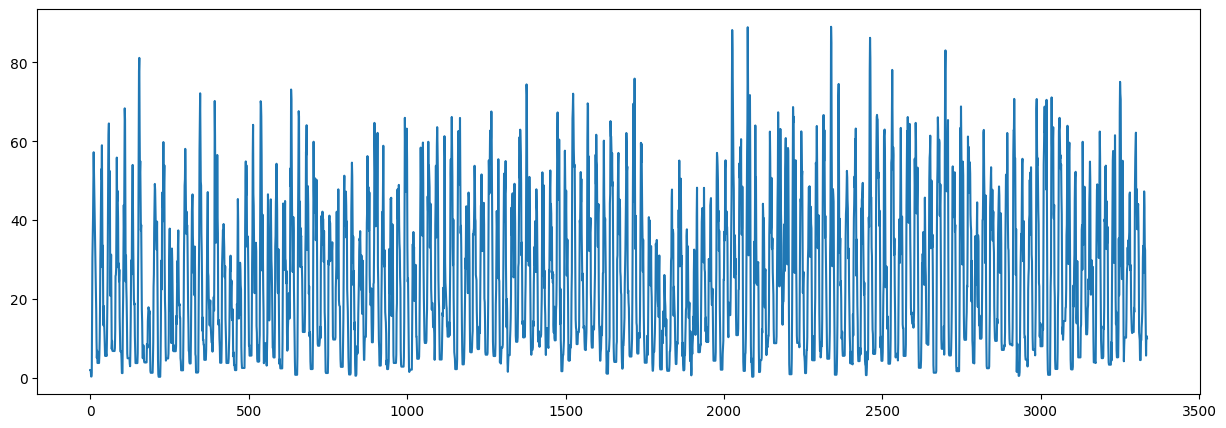

In [10]:
#plot
colmod = ColoradoDataModule(data_dir='Colorado/Preprocessing/TestDataset/CleanedColoradoData.csv', scaler=params['scaler'], seq_len=params['seq_len'], pred_len=params['pred_len'], stride=params['stride'], batch_size=params['batch_size'], num_workers=params['num_workers'], is_persistent=params['is_persistent'])
colmod.prepare_data()
colmod.setup(stage=None)

combined_name = "RandomForestRegressor"

actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

metrics = []
plt.figure(figsize=(15, 5))
plt.plot(actuals_flat, label='Actuals')
for i, pt_file in enumerate(pt_files):
  file_path = os.path.join(folder_path, pt_file)
  predictions = torch.load(file_path)
  model_name = pt_file.split('_')[1].split('.')[0]
  # model_name = pt_file.split('.')[0].split('_')[-1] #use this with loss function names

  if type(predictions[0]) == torch.Tensor: 
    predictions = [value.item() for tensor in predictions for value in tensor.flatten()]
  elif type(predictions[0]) == np.float64:
    predictions = predictions.tolist()

  predictions = predictions[-len(actuals_flat):] # reduce length of predictions to match actuals

  metrics.append({
    'model': model_name,
    'mse': mean_squared_error(predictions, actuals_flat),
    'mae': mean_absolute_error(predictions, actuals_flat),
    'mape': mean_absolute_percentage_error(predictions, actuals_flat)})
  plt.plot(predictions, label=model_name)

loss_func_df = pd.concat([pd.DataFrame([m]) for m in metrics])
loss_func_df.set_index('model', inplace=True)
loss_func_df.to_csv(f'{folder_path}/loss_func_metrics.csv')

plt.xlabel('Samples')
plt.ylabel('Energy Consumption')
plt.title(f'Predictions vs Actuals ({combined_name})')
plt.legend()

plt.savefig(f'{folder_path}/predictions_vs_actuals_{combined_name}.png')
plt.show()

In [ ]:
actuals = []
for batch in colmod.predict_dataloader():
  x, y = batch
  actuals.extend(y.numpy())

actuals_flat = [item for sublist in actuals for item in sublist]

folder_path = f'Predictions/{combined_name}'
pt_files = [f for f in os.listdir(folder_path) if f.endswith('.pt')]

predictions = []
metrics = []

actuals_flat = actuals_flat[-500:]
belows = {}

plt.figure(figsize=(8, 5))
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Data points')
plt.ylabel('Pred-Act')
for i, pt_file in enumerate(pt_files):
    file_path = os.path.join(folder_path, pt_file)
    predictions = torch.load(file_path)
    model_name = pt_file.split('.')[0].split('_')[-1]

    if len(predictions) > len(actuals_flat):
        predictions = predictions[-len(actuals_flat):]
    if type(predictions[0]) == torch.Tensor: 
        predictions = [item.item() for sublist in predictions for item in sublist]
    elif type(predictions[0]) == np.float64:
        predictions = predictions.tolist()
    
    predictions = predictions[-500:]

    diff = np.array(predictions) - np.array(actuals_flat)
    plt.plot(diff, label=model_name)

    total_below_actuals = np.sum(np.array(predictions) < np.array(actuals_flat))
    percentage_total_below_actuals = total_below_actuals / len(predictions) * 100
    belows.update({model_name: percentage_total_below_actuals})

# save belows to csv
belows_df = pd.DataFrame(list(belows.items()), columns=['Model', 'Percentage Below Actuals'])
belows_df.to_csv(f'Predictions/belows.csv', index=False)
plt.legend()
plt.savefig(f'{folder_path}/delta_{combined_name}.png')
# plt.show()

NameError: name 'colmod' is not defined

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs

Reusing TensorBoard on port 6008 (pid 19076), started 9 days, 5:59:43 ago. (Use '!kill 19076' to kill it.)

In [ ]:
!tasklist | findstr tensorboard # find tensorboard pid
!taskkill /PID 16220 /F # kill tensorboard with pid

FINDSTR: Cannot open #
FINDSTR: Cannot open find
FINDSTR: Cannot open tensorboard
FINDSTR: Cannot open pid
ERROR: Invalid argument/option - '#'.
Type "TASKKILL /?" for usage.
